# HKL Solar Plant Performance Analysis - Improved Version

**Plant**: HKL (GGI)
**Capacity**: 269.28 kWp
**Location**: Gazipur, Bangladesh (24.022351°N, 90.295767°E)

## Analysis Pipeline:
1. **Data Loading & Validation** - Load and validate all data sources
2. **Data Cleaning** - Handle duplicates, missing values, outliers
3. **Feature Engineering** - Solar position, weather integration, expected performance
4. **Quality Assessment** - Data completeness, anomaly detection
5. **Performance Analysis** - PR calculation, loss analysis, trends
6. **Visualization** - Professional reporting charts

In [1]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from typing import Tuple, Dict, Optional

# Solar-specific
import pvlib
from pvlib.location import Location

# ML for anomaly detection
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Environment
from dotenv import load_dotenv
import os

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
pd.set_option('display.max_columns', None)

load_dotenv()
ow_key = os.getenv('ow_key')

## Configuration
Centralized configuration for easy adjustments

In [2]:
# Plant configuration
PLANT_CONFIG = {
    'name': 'HKL (GGI)',
    'capacity_kwp': 269.28,
    'latitude': 24.022350694140282,
    'longitude': 90.29576719011767,
    'timezone': 'Asia/Dhaka',
    'typical_pr': 0.82,  # Typical performance ratio
    'temp_coefficient': -0.004,  # -0.4%/°C
    'stc_temp': 25  # Standard Test Conditions temperature
}

# Data quality thresholds
QUALITY_CONFIG = {
    'min_completeness': 0.70,  # Minimum 70% data completeness
    'anomaly_contamination': 0.02,  # 2% expected anomalies
    'min_sun_elevation': 15,  # Degrees - only flag anomalies when sun is high
    'min_ghi_threshold': 100,  # W/m² - minimum irradiance for valid production
    'min_expected_power': 15,  # kW - avoid flagging low-light periods
}

# Analysis period
ANALYSIS_CONFIG = {
    'start_date': '2024-01-01',
    'end_date': None,  # None = use all available data
    'data_frequency': '5min',
    'reporting_frequency': '1H'
}

# File paths
DATA_PATHS = {
    'inverter_plants': 'data/inverter_plants.csv',
    'generation_5m': 'data/inverter_five_minutes_generation_logs.csv',
    'weather': 'open_data/gazipur_weather.csv'
}

## Helper Functions
Reusable, well-documented functions for each step

In [3]:
def load_and_validate_generation_data(config: Dict) -> pd.DataFrame:
    """
    Load and perform initial validation of generation data.

    Args:
        config: Configuration dictionary with paths and plant info

    Returns:
        Clean DataFrame with generation data for specified plant
    """
    print("📊 Loading generation data...")

    # Load plant metadata
    df_plants = pd.read_csv(DATA_PATHS['inverter_plants'])
    df_plants['plant_address'] = df_plants['plant_address'].fillna('Gazipur')

    # Load 5-minute generation data
    df = pd.read_csv(DATA_PATHS['generation_5m'])

    # Parse dates
    df['generation_date'] = pd.to_datetime(df['generation_date'])

    # Merge plant info
    df = df.merge(
        df_plants[['plant_id', 'plant_name', 'plant_address', 'plant_capacity']],
        on='plant_id',
        how='left'
    )

    # Filter for HKL plant
    df = df[df['plant_name'] == PLANT_CONFIG['name']].copy()

    if len(df) == 0:
        raise ValueError(f"No data found for plant: {PLANT_CONFIG['name']}")

    print(f"✓ Loaded {len(df):,} records for {PLANT_CONFIG['name']}")
    return df


def clean_generation_data(df: pd.DataFrame, config: Dict) -> pd.DataFrame:
    """
    Clean and prepare generation data.

    - Remove commas from numeric values
    - Convert to proper units (kWh)
    - Handle timezone
    - Remove duplicates
    - Filter date range
    """
    print("\n🧹 Cleaning generation data...")
    df = df.copy()
    initial_count = len(df)

    # Clean generation_amount: remove commas, convert to float
    df['generation_amount'] = (
        df['generation_amount']
        .astype(str)
        .str.replace(',', '')
        .astype(float)
    )

    # Convert Wh to kWh
    df['generation_kwh'] = df['generation_amount'] / 1000

    # Localize timezone
    if df['generation_date'].dt.tz is None:
        df['generation_date'] = df['generation_date'].dt.tz_localize('UTC')
    df['generation_date'] = df['generation_date'].dt.tz_convert(PLANT_CONFIG['timezone'])

    # Filter date range (keep only 2024 onwards to avoid data quality issues)
    start_date = pd.Timestamp(ANALYSIS_CONFIG['start_date']).tz_localize(PLANT_CONFIG['timezone'])
    df = df[df['generation_date'] >= start_date].copy()
    print(f"  → Filtered to {start_date.date()} onwards: {len(df):,} records")

    # Remove duplicates (keep last)
    duplicates = df.duplicated(subset='generation_date', keep='last').sum()
    df = df.drop_duplicates(subset='generation_date', keep='last')
    print(f"  → Removed {duplicates:,} duplicate timestamps")

    # Sort by date
    df = df.sort_values('generation_date').reset_index(drop=True)

    # Keep only needed columns
    df = df[[
        'generation_date',
        'generation_kwh',
        'plant_name',
        'plant_capacity'
    ]].copy()

    print(f"✓ Cleaned data: {len(df):,} records retained ({len(df)/initial_count:.1%})")
    return df


def fill_missing_timestamps(df: pd.DataFrame, config: Dict) -> Tuple[pd.DataFrame, Dict]:
    """
    Create complete time series with missing timestamps filled.

    Returns:
        DataFrame with complete time series and statistics dict
    """
    print("\n⏰ Filling missing timestamps...")

    start_date = df['generation_date'].min()
    end_date = df['generation_date'].max()

    # Create complete date range
    full_index = pd.date_range(
        start=start_date,
        end=end_date,
        freq='5min',
        tz=PLANT_CONFIG['timezone']
    )

    # Reindex to fill gaps
    df_complete = df.set_index('generation_date').reindex(full_index).reset_index()
    df_complete = df_complete.rename(columns={'index': 'generation_date'})

    # Fill constant values
    df_complete['plant_name'] = PLANT_CONFIG['name']
    df_complete['plant_capacity'] = PLANT_CONFIG['capacity_kwp']

    # Calculate statistics
    stats = {
        'expected_points': len(full_index),
        'available_points': df['generation_kwh'].notna().sum(),
        'missing_points': len(full_index) - df['generation_kwh'].notna().sum(),
        'completeness': len(df) / len(full_index)
    }

    print(f"  → Expected points: {stats['expected_points']:,}")
    print(f"  → Available points: {stats['available_points']:,}")
    print(f"  → Missing points: {stats['missing_points']:,}")
    print(f"  → Completeness: {stats['completeness']:.1%}")

    if stats['completeness'] < QUALITY_CONFIG['min_completeness']:
        print(f"  ⚠️  Warning: Completeness below threshold ({QUALITY_CONFIG['min_completeness']:.0%})")

    return df_complete, stats

In [4]:
def add_solar_position_data(df: pd.DataFrame, config: Dict) -> pd.DataFrame:
    """
    Add solar position (elevation, azimuth) and clear-sky irradiance.

    Uses pvlib for accurate solar calculations.
    """
    print("\n☀️  Calculating solar position...")

    # Create location object
    location = Location(
        latitude=PLANT_CONFIG['latitude'],
        longitude=PLANT_CONFIG['longitude'],
        tz=PLANT_CONFIG['timezone']
    )

    # Calculate solar position
    times = pd.DatetimeIndex(df['generation_date'])
    solpos = location.get_solarposition(times)
    clearsky = location.get_clearsky(times)

    # Add to dataframe
    df['elevation'] = solpos['elevation'].values
    df['azimuth'] = solpos['azimuth'].values
    df['ghi'] = clearsky['ghi'].values  # Global Horizontal Irradiance

    # Daytime flag (sun above horizon)
    df['is_daytime'] = df['elevation'] > 0

    print(f"✓ Added solar position data")
    print(f"  → Daytime periods: {df['is_daytime'].sum():,} ({df['is_daytime'].mean():.1%})")

    return df


def add_weather_data(df: pd.DataFrame, config: Dict) -> pd.DataFrame:
    """
    Load and merge weather data.
    """
    print("\n🌤️  Loading weather data...")

    weather = pd.read_csv(DATA_PATHS['weather'])

    # Parse timestamps
    weather['generation_date'] = pd.to_datetime(
        weather['dt_iso'].str.replace(' UTC', ''),
        utc=True
    ).dt.tz_convert(PLANT_CONFIG['timezone'])

    # Select and rename columns
    weather = weather[[
        'generation_date',
        'temp',
        'visibility',
        'rain_1h',
        'clouds_all'
    ]].copy()

    # Handle duplicates by averaging
    weather = weather.groupby('generation_date').agg({
        'temp': 'mean',
        'visibility': 'mean',
        'rain_1h': 'sum',
        'clouds_all': 'mean'
    }).reset_index()

    # Merge with generation data
    df = df.merge(weather, on='generation_date', how='left')

    # Interpolate missing weather values
    df['temp'] = df['temp'].interpolate(method='linear', limit_direction='both')
    df['visibility'] = df['visibility'].interpolate(method='linear', limit_direction='both')
    df['clouds_all'] = df['clouds_all'].interpolate(method='linear', limit_direction='both')
    df['rain_1h'] = df['rain_1h'].fillna(0)  # Assume no rain if missing

    print(f"✓ Weather data merged")

    return df


def calculate_expected_performance(df: pd.DataFrame, config: Dict) -> pd.DataFrame:
    """
    Calculate expected power output based on:
    - Clear-sky GHI
    - Plant capacity
    - Typical performance ratio
    - Temperature coefficient
    """
    print("\n📐 Calculating expected performance...")

    capacity = PLANT_CONFIG['capacity_kwp']
    pr = PLANT_CONFIG['typical_pr']
    temp_coef = PLANT_CONFIG['temp_coefficient']
    stc_temp = PLANT_CONFIG['stc_temp']

    # Temperature effect (lower temp = better performance)
    df['temp_effect'] = 1 + temp_coef * (stc_temp - df['temp'])

    # Expected power (kW) at this instant
    df['expected_power_kw'] = (df['ghi'] / 1000) * capacity * pr * df['temp_effect']

    # Expected energy for 5-minute interval (kWh)
    df['expected_energy_kwh'] = df['expected_power_kw'] * (5 / 60)

    # Actual instantaneous power (kW) - convert 5-min kWh to kW
    df['actual_power_kw'] = df['generation_kwh'] * 12  # 12 five-minute periods per hour

    # Instantaneous Performance Ratio
    df['pr_instantaneous'] = df['actual_power_kw'] / df['expected_power_kw'].replace(0, np.nan)

    print(f"✓ Expected performance calculated")

    return df

In [5]:
def smart_fill_missing_generation(df: pd.DataFrame, config: Dict) -> pd.DataFrame:
    """
    Intelligently fill missing generation data:

    1. Night (elevation < 0) → Force to 0
    2. Short gaps (< 2 hours) → Linear interpolation
    3. Medium gaps (2h - 7 days) during high sun → Use clear-sky expectation
    4. Long gaps (> 7 days) → Flag and leave as NaN
    """
    print("\n🔧 Smart-filling missing generation data...")

    df = df.copy()
    energy = df['generation_kwh'].copy()
    initial_missing = energy.isna().sum()

    # Step 1: Night → 0
    night_mask = df['elevation'] < 0
    energy[night_mask] = 0
    filled_night = initial_missing - energy.isna().sum()

    # Step 2: Short gaps → Linear interpolation (max 24 points = 2 hours)
    energy = energy.interpolate(method='linear', limit=24)
    filled_short = initial_missing - filled_night - energy.isna().sum()

    # Step 3: Medium gaps with good sun → Clear-sky expectation
    medium_gap_mask = (
        energy.isna() &
        (df['elevation'] > 10) &
        (df['ghi'] > 50)
    )
    energy[medium_gap_mask] = df.loc[medium_gap_mask, 'expected_energy_kwh']
    filled_medium = initial_missing - filled_night - filled_short - energy.isna().sum()

    # Step 4: Long gaps → Flag
    df['long_gap'] = energy.isna().astype(int)
    remaining_missing = energy.isna().sum()

    df['generation_kwh_filled'] = energy

    print(f"  → Initial missing: {initial_missing:,}")
    print(f"  → Filled (night=0): {filled_night:,}")
    print(f"  → Filled (interpolation): {filled_short:,}")
    print(f"  → Filled (clear-sky): {filled_medium:,}")
    print(f"  → Remaining (flagged): {remaining_missing:,}")
    print(f"✓ Smart-fill complete")

    return df

In [6]:
def detect_anomalies(df: pd.DataFrame, config: Dict) -> pd.DataFrame:
    """
    Detect anomalies using Isolation Forest on relevant features.

    Only flags anomalies during high-sun periods to avoid false positives.
    """
    print("\n🔍 Detecting anomalies...")

    # Add temporal features
    df['hour'] = df['generation_date'].dt.hour
    df['dayofyear'] = df['generation_date'].dt.dayofyear
    df['month'] = df['generation_date'].dt.month

    # Features for anomaly detection
    features = [
        'hour',
        'dayofyear',
        'ghi',
        'temp',
        'clouds_all',
        'visibility',
        'pr_instantaneous'
    ]

    # Prepare data (remove NaN)
    X = df[features].copy()
    X = X.ffill().bfill().fillna(0)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train Isolation Forest
    iso = IsolationForest(
        contamination=QUALITY_CONFIG['anomaly_contamination'],
        random_state=42,
        n_jobs=-1
    )
    iso.fit(X_scaled)

    # Predict anomalies
    df['anomaly_score'] = iso.decision_function(X_scaled)
    df['is_anomaly_raw'] = iso.predict(X_scaled) == -1

    # Only flag anomalies during valid production periods
    valid_production_mask = (
        (df['elevation'] > QUALITY_CONFIG['min_sun_elevation']) &
        (df['ghi'] > QUALITY_CONFIG['min_ghi_threshold']) &
        (df['expected_power_kw'] > QUALITY_CONFIG['min_expected_power'])
    )

    df['is_anomaly'] = df['is_anomaly_raw'] & valid_production_mask

    # Reset anomaly score for invalid periods
    df.loc[~valid_production_mask, 'anomaly_score'] = 0.5

    anomaly_count = df['is_anomaly'].sum()
    anomaly_pct = anomaly_count / len(df)

    print(f"✓ Detected {anomaly_count:,} anomalous periods ({anomaly_pct:.2%})")

    return df

In [7]:
def resample_to_hourly(df: pd.DataFrame, config: Dict) -> pd.DataFrame:
    """
    Resample 5-minute data to hourly for easier analysis and reporting.
    """
    print("\n⏱️  Resampling to hourly...")

    df_hourly = (
        df.set_index('generation_date')
        .resample('1H')
        .agg({
            'generation_kwh': 'sum',
            'generation_kwh_filled': 'sum',
            'expected_energy_kwh': 'sum',
            'actual_power_kw': 'mean',
            'expected_power_kw': 'mean',
            'ghi': 'mean',
            'elevation': 'mean',
            'temp': 'mean',
            'clouds_all': 'mean',
            'visibility': 'mean',
            'rain_1h': 'sum',
            'is_daytime': 'max',
            'is_anomaly': 'max',  # Flag hour as anomalous if any 5-min period is
            'long_gap': 'max',
            'plant_capacity': 'first',
            'plant_name': 'first'
        })
        .reset_index()
    )

    # Calculate hourly PR
    df_hourly['pr_hourly'] = (
        df_hourly['generation_kwh'] /
        df_hourly['expected_energy_kwh'].replace(0, np.nan)
    )

    print(f"✓ Resampled to {len(df_hourly):,} hourly records")

    return df_hourly


def calculate_daily_metrics(df_hourly: pd.DataFrame, config: Dict) -> pd.DataFrame:
    """
    Calculate daily performance metrics.
    """
    print("\n📊 Calculating daily metrics...")

    df_daily = (
        df_hourly.set_index('generation_date')
        .resample('D')
        .agg({
            'generation_kwh': 'sum',
            'generation_kwh_filled': 'sum',
            'expected_energy_kwh': 'sum',
            'temp': 'mean',
            'clouds_all': 'mean',
            'rain_1h': 'sum',
            'is_anomaly': 'sum',  # Count anomalous hours per day
        })
        .reset_index()
    )

    # Rename columns for clarity
    df_daily = df_daily.rename(columns={
        'generation_kwh': 'energy_kwh',
        'generation_kwh_filled': 'energy_kwh_filled',
        'expected_energy_kwh': 'expected_kwh',
        'rain_1h': 'daily_rain_mm',
        'is_anomaly': 'anomaly_hours'
    })

    # Daily PR
    df_daily['pr_daily'] = (
        df_daily['energy_kwh'] /
        df_daily['expected_kwh'].replace(0, np.nan)
    )

    # 30-day rolling averages
    df_daily['energy_30d'] = df_daily['energy_kwh'].rolling(30, min_periods=1, center=True).mean()
    df_daily['expected_30d'] = df_daily['expected_kwh'].rolling(30, min_periods=1, center=True).mean()
    df_daily['pr_30d'] = df_daily['pr_daily'].rolling(30, min_periods=1, center=True).mean()

    print(f"✓ Calculated metrics for {len(df_daily):,} days")

    return df_daily

In [8]:
def plot_production_overview(df_hourly: pd.DataFrame, df_daily: pd.DataFrame,
                            start_date: str = None, end_date: str = None):
    """
    Create comprehensive production overview plot.
    """
    # Filter date range if specified
    if start_date or end_date:
        mask = pd.Series(True, index=df_hourly.index)
        if start_date:
            mask &= df_hourly['generation_date'] >= start_date
        if end_date:
            mask &= df_hourly['generation_date'] <= end_date
        df_h = df_hourly[mask].copy()
    else:
        df_h = df_hourly.copy()

    # Get anomalies
    anomalies = df_h[df_h['is_anomaly']]

    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), height_ratios=[2, 1])

    # Plot 1: Production comparison
    ax1.plot(df_h['generation_date'], df_h['expected_energy_kwh'],
            color='orange', linewidth=2, label='Expected (clear-sky + temp)', alpha=0.8)
    ax1.plot(df_h['generation_date'], df_h['generation_kwh_filled'],
            color='steelblue', linewidth=1.5, label='Actual production', alpha=0.9)
    ax1.scatter(anomalies['generation_date'], anomalies['generation_kwh_filled'],
               color='red', s=40, label='Anomaly detected', zorder=5, alpha=0.7)

    ax1.set_title(f"Hourly Production - {PLANT_CONFIG['name']} ({PLANT_CONFIG['capacity_kwp']} kWp)\n"
                 f"Anomalies detected: {len(anomalies)} hours",
                 fontsize=16, pad=20, fontweight='bold')
    ax1.set_ylabel('Energy (kWh/hour)', fontsize=13)
    ax1.legend(fontsize=12, loc='upper left')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Performance Ratio
    valid_pr = df_h[df_h['is_daytime'] & (df_h['pr_hourly'] > 0) & (df_h['pr_hourly'] < 2)]
    ax2.scatter(valid_pr['generation_date'], valid_pr['pr_hourly'],
               s=5, alpha=0.3, color='steelblue')

    # Add reference lines
    ax2.axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='Excellent (>0.95)')
    ax2.axhline(y=0.85, color='orange', linestyle='--', alpha=0.7, label='Good (>0.85)')
    ax2.axhline(y=0.75, color='red', linestyle='--', alpha=0.7, label='Attention (<0.75)')

    ax2.set_title('Hourly Performance Ratio (daytime only)', fontsize=14, pad=15)
    ax2.set_ylabel('PR', fontsize=13)
    ax2.set_xlabel('Date', fontsize=13)
    ax2.set_ylim(0, 1.2)
    ax2.legend(fontsize=11, loc='upper right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_daily_trends(df_daily: pd.DataFrame):
    """
    Plot daily production with 30-day trends.
    """
    fig, ax = plt.subplots(figsize=(20, 9))

    # Bar chart of daily production
    ax.bar(df_daily['generation_date'], df_daily['energy_kwh'],
          color='steelblue', alpha=0.6, width=1, label='Daily production')

    # Trend lines
    ax.plot(df_daily['generation_date'], df_daily['energy_30d'],
           color='green', linewidth=4, label='Actual trend (30-day avg)', zorder=10)
    ax.plot(df_daily['generation_date'], df_daily['expected_30d'],
           color='orange', linewidth=4, linestyle='--',
           label='Clear-sky potential (30-day avg)', zorder=10)

    ax.set_title(f"Daily Production Trends - {PLANT_CONFIG['name']}\n"
                f"Green = Actual | Orange = Clear-sky potential",
                fontsize=16, pad=20, fontweight='bold')
    ax.set_ylabel('Energy (kWh/day)', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    ax.legend(fontsize=13, loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, ax.get_ylim()[1])

    plt.tight_layout()
    plt.show()


def plot_pr_analysis(df_daily: pd.DataFrame):
    """
    Plot Performance Ratio analysis with trends.
    """
    fig, ax = plt.subplots(figsize=(20, 8))

    # Interpolate PR for continuous line (only for visualization)
    pr_plot = df_daily['pr_daily'].interpolate(method='linear', limit_direction='both')

    ax.plot(df_daily['generation_date'], pr_plot,
           color='steelblue', linewidth=2, label='Daily PR', alpha=0.7)
    ax.plot(df_daily['generation_date'], df_daily['pr_30d'],
           color='black', linewidth=3, label='30-day trend', zorder=10)

    # Reference lines
    ax.axhline(y=0.95, color='darkgreen', linestyle='--', linewidth=2, alpha=0.8, label='Excellent')
    ax.axhline(y=0.85, color='orange', linestyle='--', linewidth=2, alpha=0.8, label='Good')
    ax.axhline(y=0.75, color='red', linestyle='--', linewidth=2, alpha=0.8, label='Needs attention')

    # Calculate stats
    mean_pr = df_daily['pr_daily'].mean()
    median_pr = df_daily['pr_daily'].median()

    ax.set_title(f"Performance Ratio Analysis - {PLANT_CONFIG['name']}\n"
                f"Mean PR: {mean_pr:.2%} | Median PR: {median_pr:.2%}",
                fontsize=16, pad=20, fontweight='bold')
    ax.set_ylabel('Performance Ratio', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylim(0.5, 1.1)
    ax.legend(fontsize=12, loc='lower left')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def print_summary_statistics(df: pd.DataFrame, df_hourly: pd.DataFrame,
                            df_daily: pd.DataFrame, stats: Dict):
    """
    Print comprehensive summary statistics.
    """
    print("\n" + "="*80)
    print(f"  PERFORMANCE SUMMARY - {PLANT_CONFIG['name']}")
    print("="*80)

    # Date range
    start = df['generation_date'].min()
    end = df['generation_date'].max()
    days = (end - start).days + 1
    print(f"\nAnalysis Period: {start.date()} to {end.date()} ({days} days)")

    # Data quality
    print(f"\n📊 Data Quality:")
    print(f"  Completeness: {stats['completeness']:.1%}")
    print(f"  Missing points: {stats['missing_points']:,} / {stats['expected_points']:,}")
    print(f"  Anomalies detected: {df['is_anomaly'].sum():,} periods ({df['is_anomaly'].mean():.2%})")

    # Production statistics
    total_actual = df_daily['energy_kwh'].sum()
    total_expected = df_daily['expected_kwh'].sum()
    overall_pr = total_actual / total_expected

    print(f"\n⚡ Production Statistics:")
    print(f"  Total production: {total_actual:,.0f} kWh")
    print(f"  Expected (clear-sky): {total_expected:,.0f} kWh")
    print(f"  Average daily production: {df_daily['energy_kwh'].mean():.0f} kWh/day")
    print(f"  Best day: {df_daily['energy_kwh'].max():.0f} kWh on {df_daily.loc[df_daily['energy_kwh'].idxmax(), 'generation_date'].date()}")

    print(f"\n🎯 Performance Ratio:")
    print(f"  Overall PR: {overall_pr:.2%}")
    print(f"  Average daily PR: {df_daily['pr_daily'].mean():.2%}")
    print(f"  Median daily PR: {df_daily['pr_daily'].median():.2%}")
    print(f"  30-day trend (latest): {df_daily['pr_30d'].iloc[-1]:.2%}")

    # Performance rating
    if overall_pr >= 0.95:
        rating = "🟢 EXCELLENT"
    elif overall_pr >= 0.85:
        rating = "🟡 GOOD"
    elif overall_pr >= 0.75:
        rating = "🟠 FAIR - Maintenance recommended"
    else:
        rating = "🔴 POOR - Immediate attention required"

    print(f"\n  → System Status: {rating}")

    # Loss analysis
    energy_loss = total_expected - total_actual
    loss_pct = (1 - overall_pr) * 100

    print(f"\n📉 Loss Analysis:")
    print(f"  Total energy loss: {energy_loss:,.0f} kWh ({loss_pct:.1f}% of potential)")
    print(f"  Days with PR < 0.75: {(df_daily['pr_daily'] < 0.75).sum()} days")

    print("\n" + "="*80)

---
# Main Analysis Pipeline
Execute all steps in sequence

In [9]:
# Step 1: Load raw data
df_raw = load_and_validate_generation_data(PLANT_CONFIG)

📊 Loading generation data...
✓ Loaded 157,090 records for HKL (GGI)


In [10]:
# Step 2: Clean data
df_clean = clean_generation_data(df_raw, PLANT_CONFIG)


🧹 Cleaning generation data...
  → Filtered to 2024-01-01 onwards: 154,383 records
  → Removed 816 duplicate timestamps
✓ Cleaned data: 153,567 records retained (97.8%)


In [11]:
# Step 3: Fill missing timestamps
df_complete, data_quality_stats = fill_missing_timestamps(df_clean, PLANT_CONFIG)


⏰ Filling missing timestamps...
  → Expected points: 190,342
  → Available points: 153,567
  → Missing points: 36,775
  → Completeness: 80.7%


In [12]:
# Step 4: Add solar position data
df_solar = add_solar_position_data(df_complete, PLANT_CONFIG)


☀️  Calculating solar position...
✓ Added solar position data
  → Daytime periods: 96,419 (50.7%)


In [13]:
# Step 5: Add weather data
df_weather = add_weather_data(df_solar, PLANT_CONFIG)


🌤️  Loading weather data...
✓ Weather data merged


In [14]:
# Step 6: Calculate expected performance
df_expected = calculate_expected_performance(df_weather, PLANT_CONFIG)


📐 Calculating expected performance...
✓ Expected performance calculated


In [15]:
# Step 7: Smart-fill missing generation
df_filled = smart_fill_missing_generation(df_expected, PLANT_CONFIG)


🔧 Smart-filling missing generation data...
  → Initial missing: 36,775
  → Filled (night=0): 24,838
  → Filled (interpolation): 5,463
  → Filled (clear-sky): 5,949
  → Remaining (flagged): 525
✓ Smart-fill complete


In [16]:
# Step 8: Detect anomalies
df_analyzed = detect_anomalies(df_filled, QUALITY_CONFIG)


🔍 Detecting anomalies...
✓ Detected 695 anomalous periods (0.37%)


In [17]:
# Step 9: Resample to hourly
df_hourly = resample_to_hourly(df_analyzed, ANALYSIS_CONFIG)


⏱️  Resampling to hourly...
✓ Resampled to 15,862 hourly records


In [18]:
# Step 10: Calculate daily metrics
df_daily = calculate_daily_metrics(df_hourly, ANALYSIS_CONFIG)


📊 Calculating daily metrics...
✓ Calculated metrics for 661 days


---
# Results & Visualization

In [19]:
# Print comprehensive summary
print_summary_statistics(df_analyzed, df_hourly, df_daily, data_quality_stats)


  PERFORMANCE SUMMARY - HKL (GGI)

Analysis Period: 2024-01-01 to 2025-10-22 (661 days)

📊 Data Quality:
  Completeness: 80.7%
  Missing points: 36,775 / 190,342
  Anomalies detected: 695 periods (0.37%)

⚡ Production Statistics:
  Total production: 473,359 kWh
  Expected (clear-sky): 913,962 kWh
  Average daily production: 716 kWh/day
  Best day: 1320 kWh on 2025-03-25

🎯 Performance Ratio:
  Overall PR: 51.79%
  Average daily PR: 53.59%
  Median daily PR: 54.75%
  30-day trend (latest): 69.36%

  → System Status: 🔴 POOR - Immediate attention required

📉 Loss Analysis:
  Total energy loss: 440,603 kWh (48.2% of potential)
  Days with PR < 0.75: 513 days



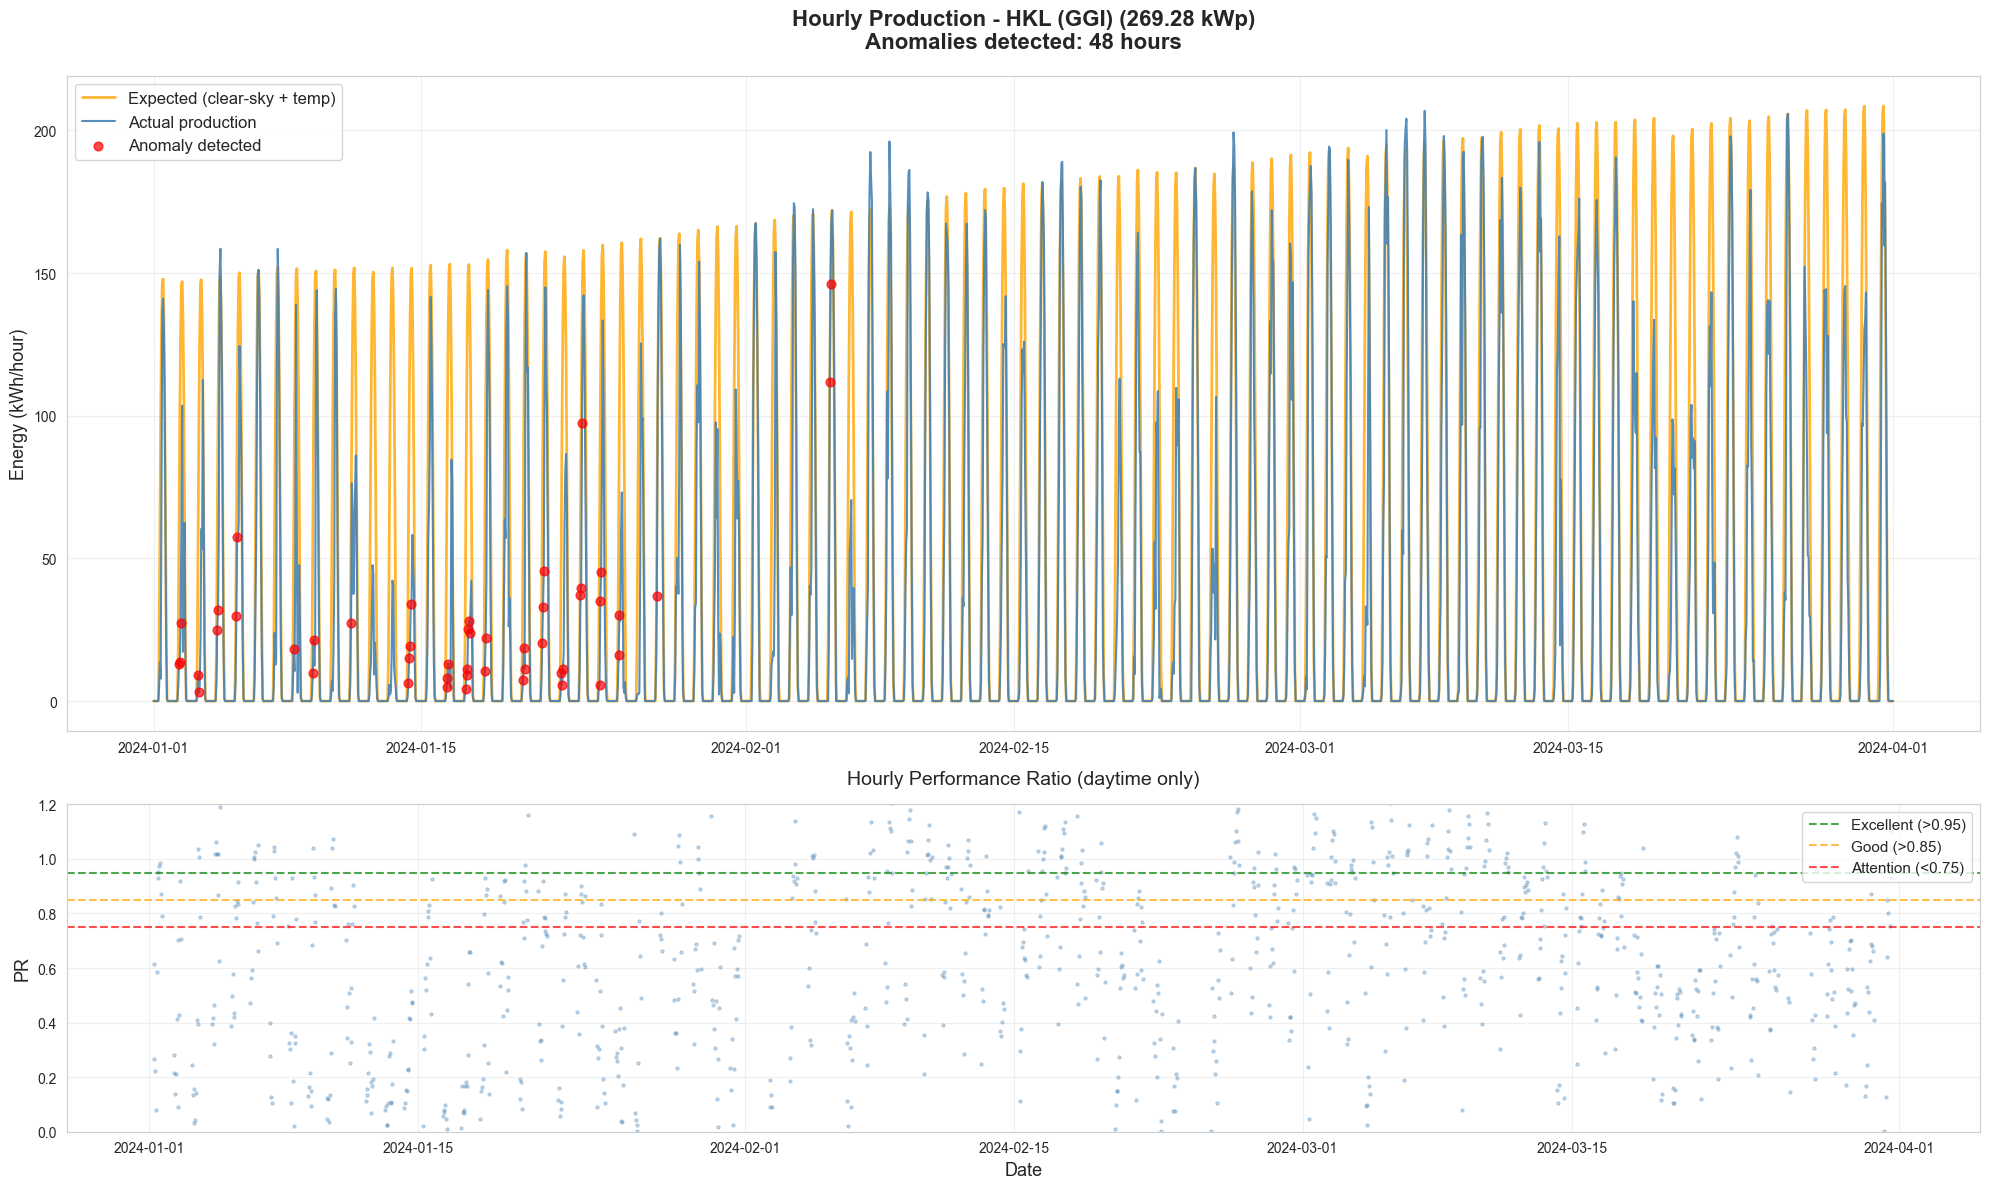

In [20]:
# Plot 1: Production overview (3 months for clarity)
plot_production_overview(df_hourly, df_daily,
                         start_date='2024-01-01',
                         end_date='2024-04-01')

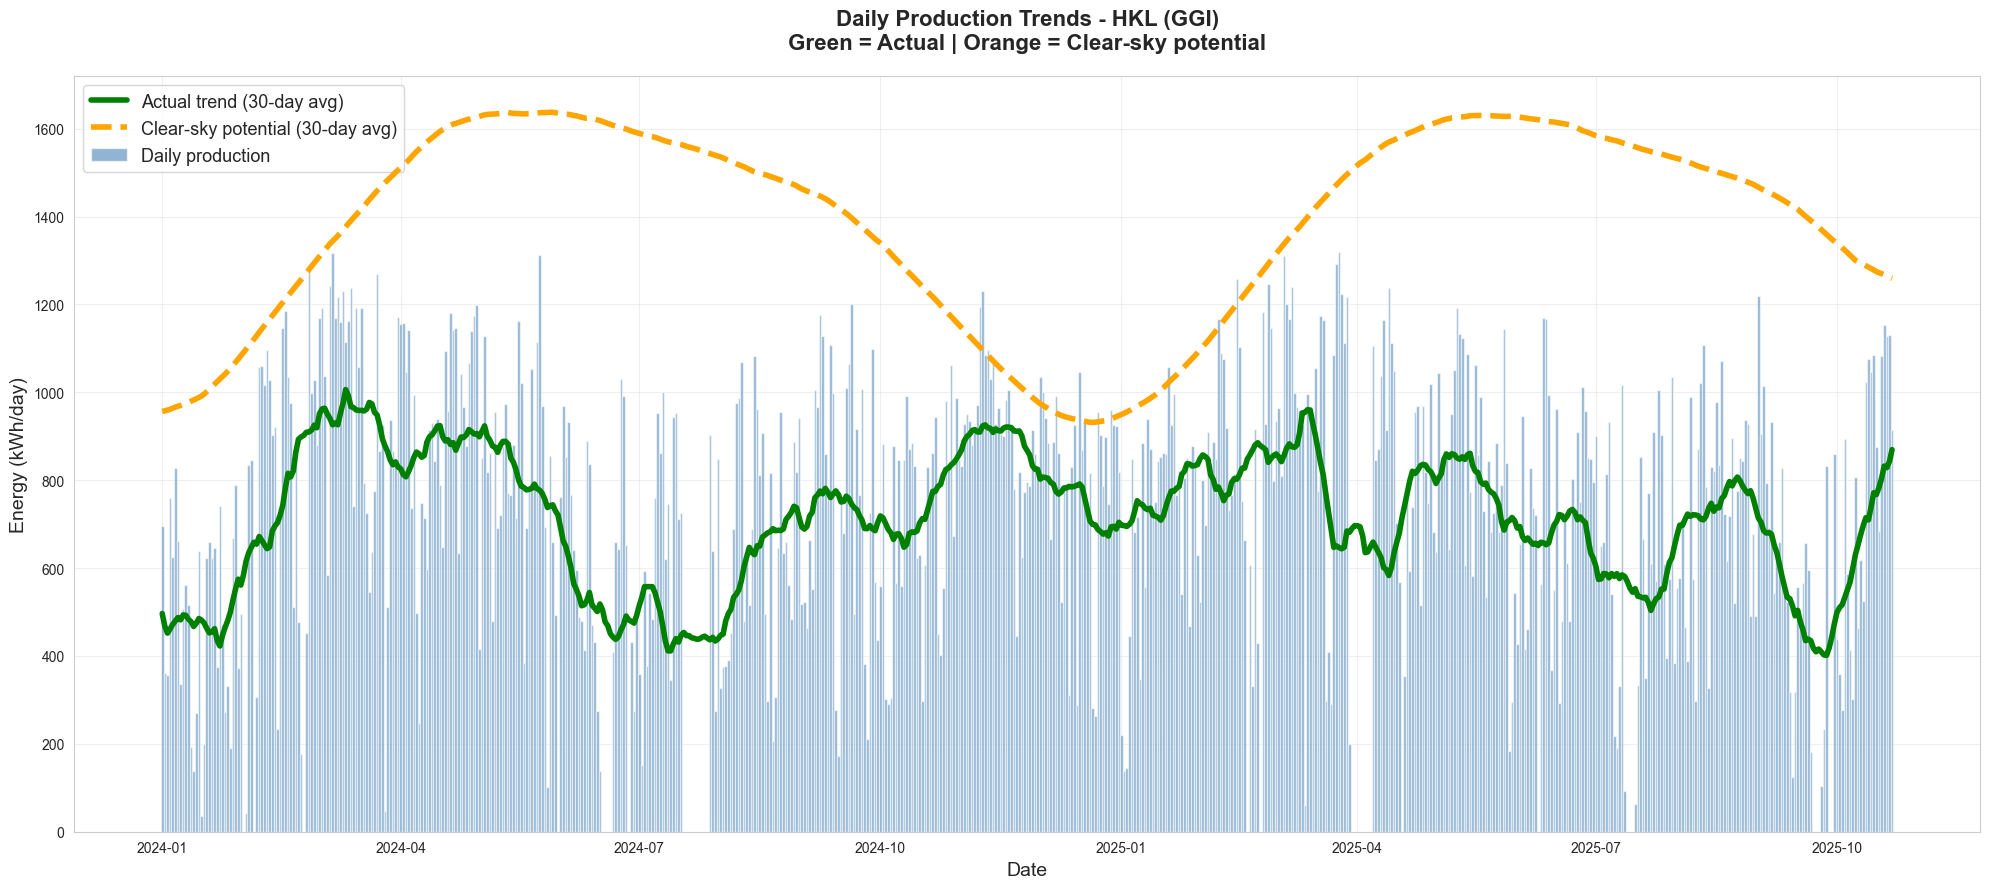

In [21]:
# Plot 2: Daily trends (full period)
plot_daily_trends(df_daily)

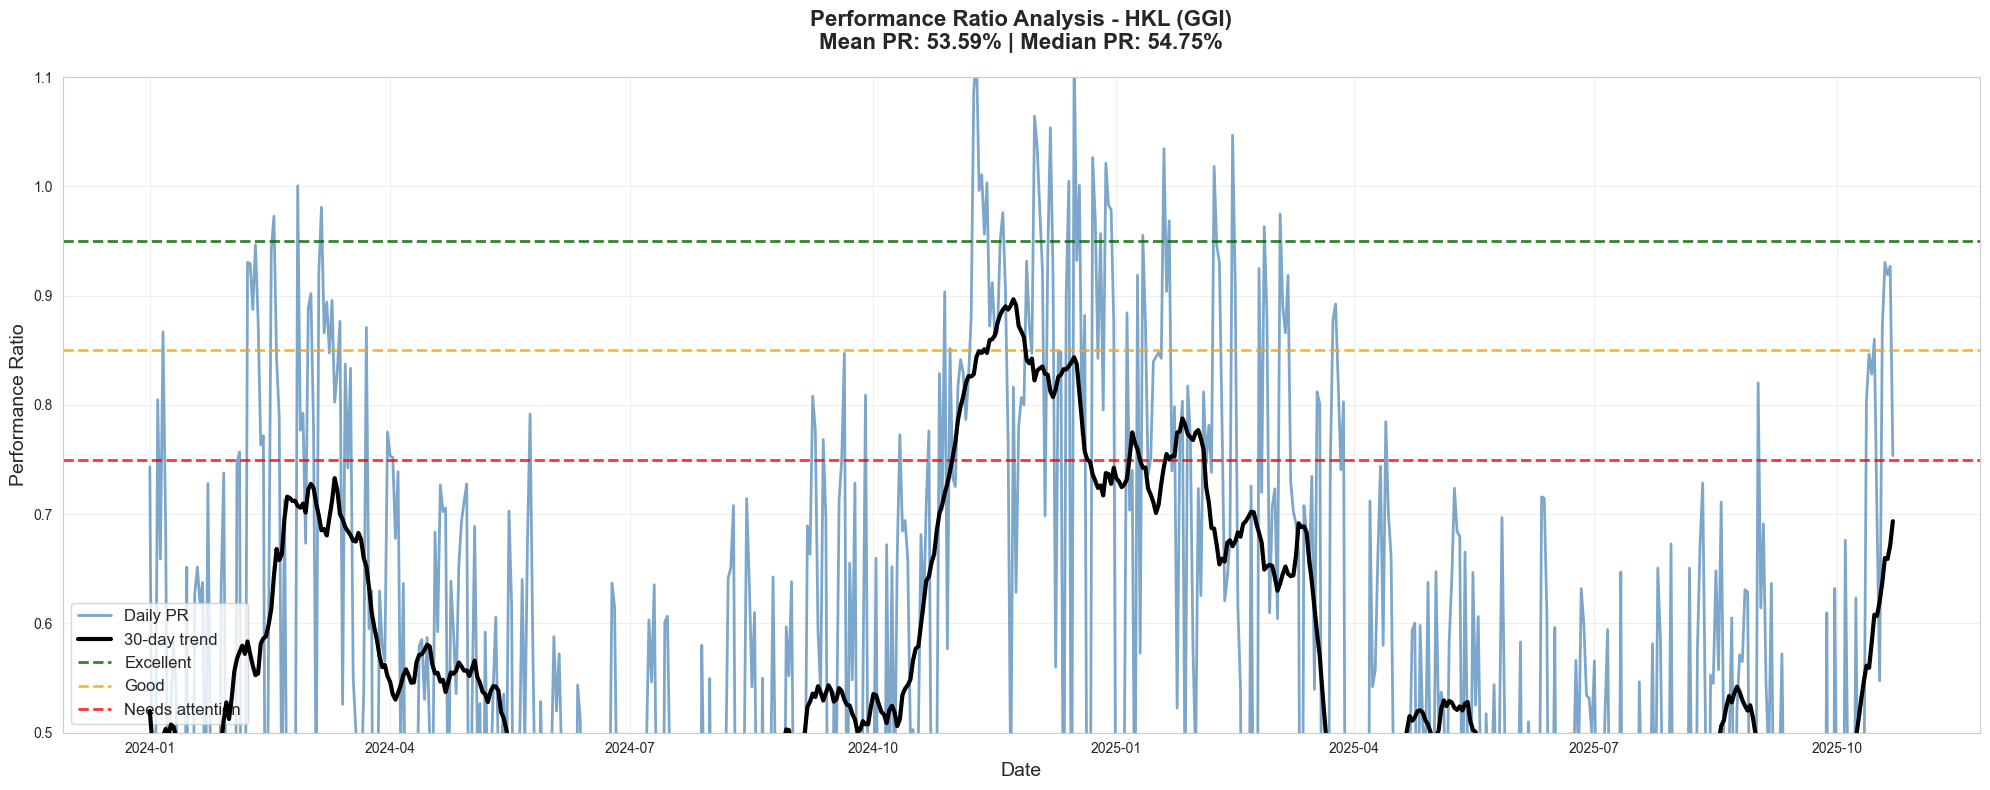

In [22]:
# Plot 3: Performance Ratio analysis
plot_pr_analysis(df_daily)

---
# Data Export
Save processed data for further analysis or reporting

In [24]:
# Export to CSV
df_hourly.to_csv('output/HKL_hourly_analysis.csv', index=False)
df_daily.to_csv('output/HKL_daily_analysis.csv', index=False)

print("✓ Data exported to output/ directory")

✓ Data exported to output/ directory


---
# Anomaly Investigation
Detailed look at detected anomalies

In [25]:
# Show worst anomalies
anomalies = df_analyzed[df_analyzed['is_anomaly']].copy()
anomalies_sorted = anomalies.sort_values('anomaly_score').head(20)

print(f"\n🔍 Top 20 Anomalies (lowest scores = most anomalous)\n")
print(anomalies_sorted[[
    'generation_date',
    'actual_power_kw',
    'expected_power_kw',
    'pr_instantaneous',
    'temp',
    'clouds_all',
    'ghi',
    'anomaly_score'
]].to_string(index=False))


🔍 Top 20 Anomalies (lowest scores = most anomalous)

          generation_date  actual_power_kw  expected_power_kw  pr_instantaneous      temp  clouds_all        ghi  anomaly_score
2024-01-17 10:00:00+06:00        17.003530         119.120225          0.142743 13.250000  100.000000 566.075886      -0.047504
2024-01-17 10:05:00+06:00         8.379980         121.685242          0.068866 13.459167   96.083333 577.757973      -0.045188
2024-01-23 08:25:00+06:00        36.403433          59.588866          0.610910 12.540000  100.000000 284.020985      -0.044934
2024-01-17 10:20:00+06:00         5.370185         128.881975          0.041667 14.086667   84.333333 610.321800      -0.044451
2024-01-17 10:15:00+06:00         6.848260         126.567706          0.054107 13.877500   88.250000 599.887374      -0.043612
2024-01-23 08:30:00+06:00        39.433053          63.330760          0.622652 12.530000  100.000000 301.868840      -0.043070
2024-01-23 08:35:00+06:00        41.586692        